First step is import the packages and bib

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
from spacepy import pycdf
from datetime import datetime
import chaosmagpy as cp
import glob
%config InlineBackend.figure_format ='retina'

Searching the file of interest and atributing her path to a variable "file_path"

In [7]:
file_path = glob.glob(f'coimbra data/MAA0*.cdf')

Heading the cdf file using the package pycdf. In the sequence, convert the cdf to a pandas DataFrame

In [8]:
data = pycdf.CDF(file_path[0])

df_cdf = pd.DataFrame()
df_cdf['F_calc'] = np.sqrt((data['HNvar'][:] + data['H0'][1])**2 + (data['HEvar'][:] + data['D0'][1])**2 + (data['Zvar'][:] + data['Z0'][1])**2 )
df_cdf['Fsc'] = data['Fsc'][:]
df_cdf['HNvar'] = data['HNvar'][:]
df_cdf['Zvar'] = data['Zvar'][:]
df_cdf['HEvar'] = data['HEvar'][:]
# [Htot] used in TTB and MAA
df_cdf['Htot'] = data['HNvar'][:] + data['H0'][1]
df_cdf.index = pd.to_datetime(cp.data_utils.timestamp(data['time'][:]))
data.close()

Looking at the dataframe

In [9]:
df_cdf

,F_calc,Fsc,HNvar,Zvar,HEvar,Htot
2021-04-26 00:00:00,23570.255222,26704.70,-110.61,-90.25,-2.64,18567.39
2021-04-26 00:00:01,23570.251787,26704.70,-110.63,-90.27,-2.64,18567.37
2021-04-26 00:00:02,23570.265856,26704.70,-110.62,-90.28,-2.67,18567.38
2021-04-26 00:00:03,23570.242224,26704.70,-110.65,-90.28,-2.67,18567.35
2021-04-26 00:00:04,23570.220298,26704.70,-110.67,-90.27,-2.66,18567.33
...,...,...,...,...,...,...
2021-04-26 23:59:55,23563.295342,26700.36,-120.29,-91.33,-1.92,18557.71
2021-04-26 23:59:56,23563.281304,26700.36,-120.30,-91.32,-1.92,18557.70
2021-04-26 23:59:57,23563.285711,26700.36,-120.31,-91.34,-1.88,18557.69
2021-04-26 23:59:58,23563.289138,26700.36,-120.29,-91.32,-1.88,18557.71


Plotting the columns to look at the signs

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

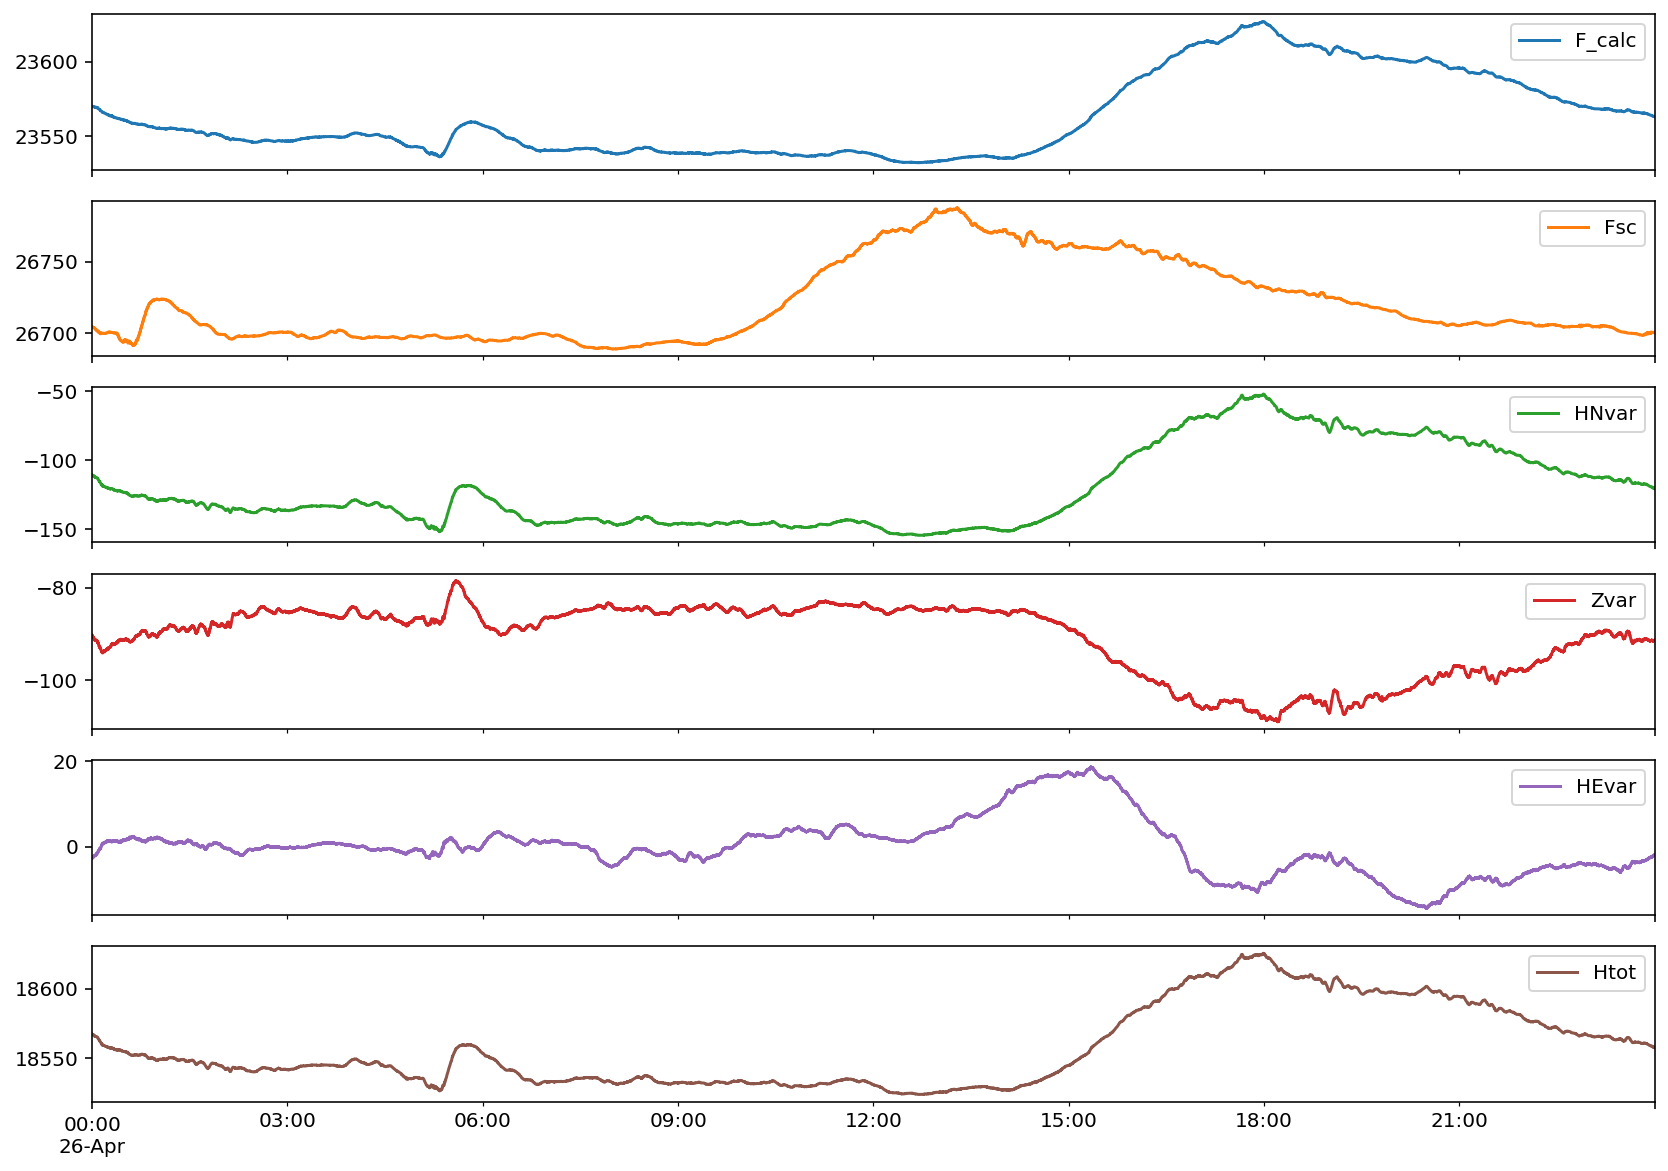

In [10]:
df_cdf.plot(subplots = True, figsize = (14,10))

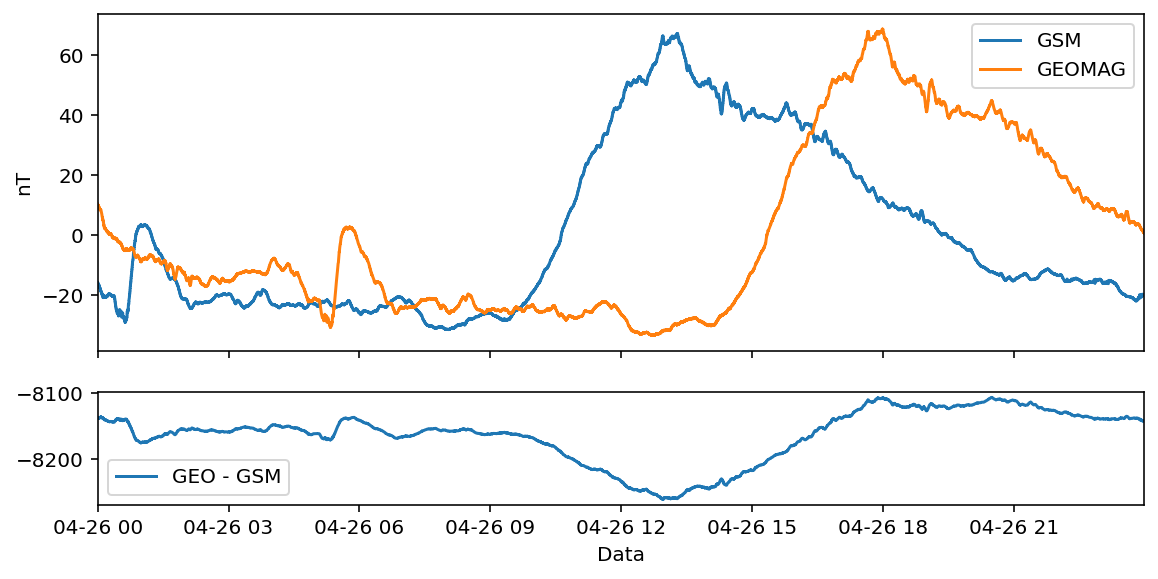

In [11]:
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize = (8,4), sharex = True)
fig.tight_layout()

#plt.figure(figsize = (10,4))
ax[0].plot(df_cdf['Fsc'] - df_cdf['Fsc'].mean(), label = 'GSM')
ax[0].plot(df_cdf['Htot'] - df_cdf['Htot'].mean(), label = 'GEOMAG')
##plt.annotate(text='', xy=(df_cdf.loc['2021-04-26 12:00:00'].name,df_cdf.loc['2021-04-26 15:00:00'].name), xytext=(0,0), arrowprops=dict(arrowstyle='<->'))
#plt.arrow(df_cdf.loc['2021-04-26 12:00:00'].name,
#          40,
#          df_cdf.loc['2021-04-26 13:00:00'].name,
#          0,
#          head_width=10,
#          head_length=0.03,
#          linewidth=4,
#          color='g',
#          length_includes_head=True
#         )
ax[1].plot(df_cdf['Htot']-df_cdf['Fsc'], label = 'GEO - GSM')
ax[1].set_xlabel('Data')
ax[0].set_ylabel('nT')
ax[1].set_xlim(df_cdf.index[0],df_cdf.index[-1])
ax[0].legend()
ax[1].legend()
plt.show()

Creating a small iteration to shift the the GEOMAG sign over the GSM and find the best correlation, hence, the corrected shift time.

In [12]:
window_size = np.arange(16000,17500,1)
coef_list = [[],[],[]]
df_coef = pd.DataFrame()
            
            
            
print(f'shifting the data to find the best adjust for {str(df_cdf.index[0].date())}')
for i in window_size:
    
    coef = df_cdf['Fsc'].corr((df_cdf['Htot']).shift(-i, 's'))
    
    coef_list[0].append(coef)
    coef_list[1].append(f'{str(timedelta(seconds=float(i)))}')
    coef_list[2].append(int(f'{i}'))
    
df_coef['coef'] = coef_list[0]
df_coef['Shift-Time (hh:mm:ss)'] = coef_list[1]
df_coef['Date'] = str(df_cdf.index[0].date())
df_coef['Shift-Time (s)'] = coef_list[2]

df_coef = df_coef.loc[df_coef['coef'] ==  df_coef['coef'].max()]

shifting the data to find the best adjust for 2021-04-26


Looking at the result

In [13]:
df_coef

,coef,Shift-Time (hh:mm:ss),Date,Shift-Time (s)
941,0.999994,4:42:21,2021-04-26,16941


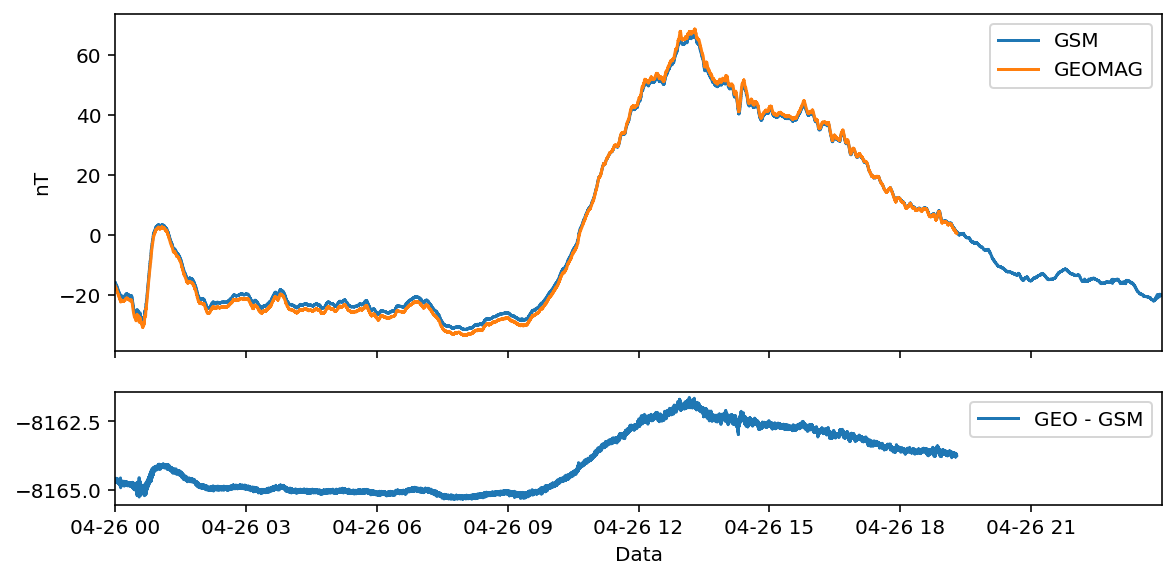

In [21]:
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize = (8,4), sharex = True)
fig.tight_layout()

#plt.figure(figsize = (10,4))
ax[0].plot(df_cdf['Fsc'] - df_cdf['Fsc'].mean(), label = 'GSM')
ax[0].plot((df_cdf['Htot'] - df_cdf['Htot'].mean()).shift(-16941, freq = 's'), label = 'GEOMAG')
##plt.annotate(text='', xy=(df_cdf.loc['2021-04-26 12:00:00'].name,df_cdf.loc['2021-04-26 15:00:00'].name), xytext=(0,0), arrowprops=dict(arrowstyle='<->'))
#plt.arrow(df_cdf.loc['2021-04-26 12:00:00'].name,
#          40,
#          df_cdf.loc['2021-04-26 13:00:00'].name,
#          0,
#          head_width=10,
#          head_length=0.03,
#          linewidth=4,
#          color='g',
#          length_includes_head=True
#         )
ax[1].plot(df_cdf['Htot'].shift(-16941, freq = 's')-df_cdf['Fsc'], label = 'GEO - GSM')
ax[1].set_xlabel('Data')
ax[0].set_ylabel('nT')
ax[1].set_xlim(df_cdf.index[0],df_cdf.index[-1])
ax[0].legend()
ax[1].legend()
plt.show()

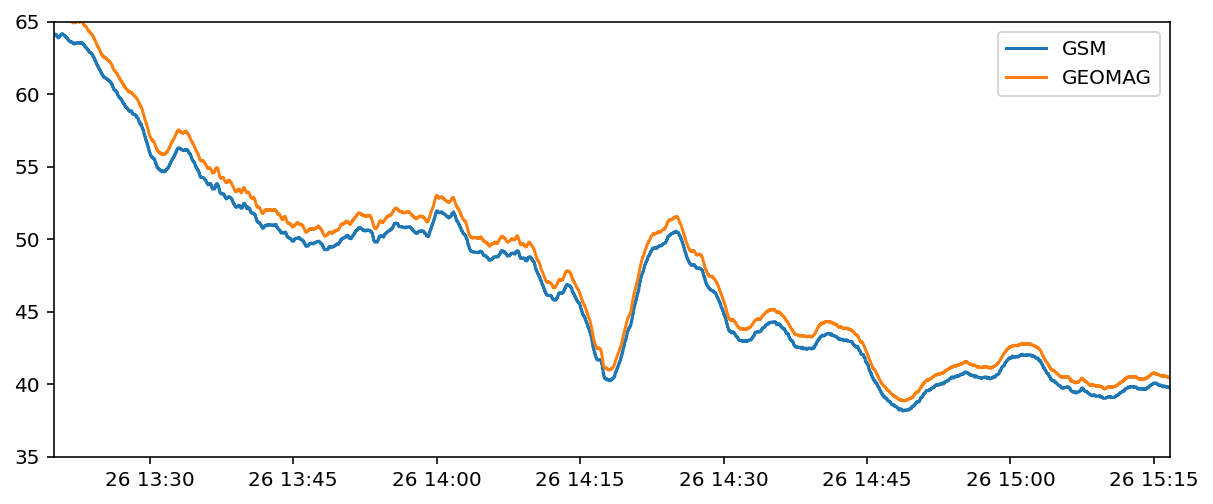

In [17]:
plt.figure(figsize = (10,4))
plt.plot(df_cdf['Fsc'] - df_cdf['Fsc'].mean(), label = 'GSM')
plt.plot((df_cdf['Htot'] - df_cdf['Htot'].mean()).shift(-16940, freq = 's'), label = 'GEOMAG')
plt.xlim(df_cdf.index[48000],df_cdf.index[55000])
plt.ylim(35,65)
plt.legend()
plt.show()